In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid", palette="muted")

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.decomposition import PCA, KernelPCA
# from sklearn.preprocessing import Imputer

In [81]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor

In [2]:
# load dataset
train = pd.read_csv("../data/House_Prices_train.csv")
test = pd.read_csv("../data/House_Prices_test.csv")

In [3]:
train.shape

(1460, 81)

In [4]:
test.shape

(1459, 80)

# 探索性数据分析

因为数据的特征较多，这里仅可视化常识上和房屋价格相关的特征，如房屋居住面积（GrLivArea）、建造年份（YearBuilt）

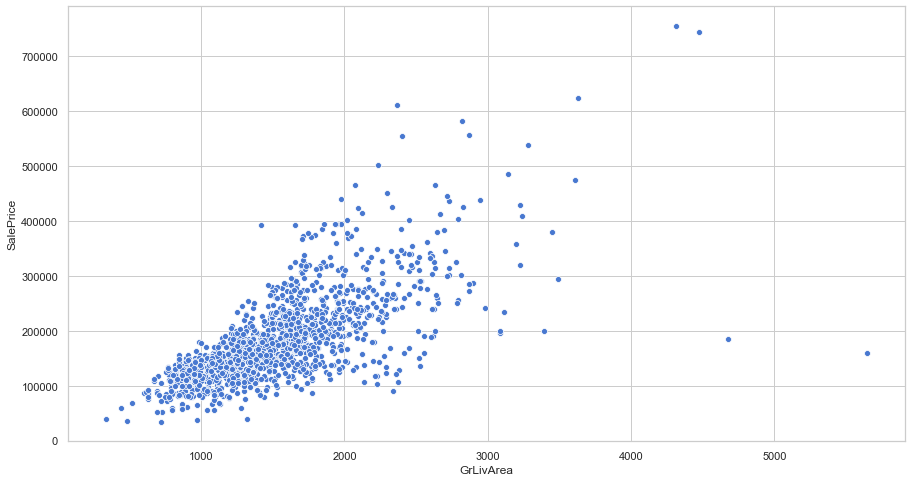

In [6]:
# 房屋居住面积与价格关系
fig = plt.figure(figsize=(15,8))
sns.scatterplot(x="GrLivArea", y="SalePrice", data=train)

发现有个别值特别的偏离，GrLivArea有两个点在4000以上，但其价格不到200000(右下角)，首先这种点特别少（不到总数的3%），这里把他作为异常值去掉。其实是否去掉可以观察一下这两个样本的实际情况，多做几次实验来验证，不过这里就简单粗暴的直接删掉。

In [7]:
train.drop(train[(train["GrLivArea"]>4000) & (train["SalePrice"]<300000)].index, inplace=True)

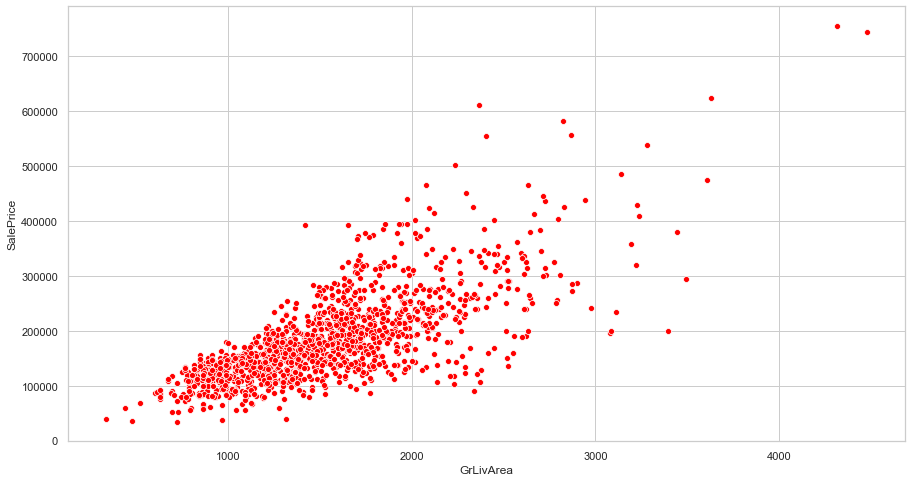

In [8]:
plt.figure(figsize=(15,8))
sns.scatterplot(x="GrLivArea", y="SalePrice", data=train, color="red")

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

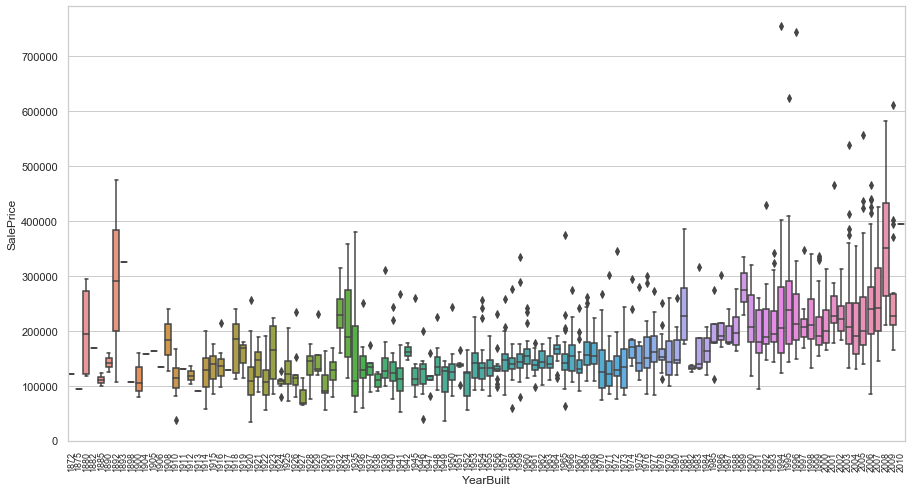

In [9]:
# 房子的建造年份与价格的关系
plt.figure(figsize=(15,8))
sns.boxplot(train.YearBuilt, train.SalePrice)
plt.xticks(rotation=90, fontsize=8)

一般认为新房子比较贵，老房子比较便宜，从图上看大致也是这个趋势，由于建造年份 (YearBuilt) 这个特征存在较多的取值 (从1872年到2010年)，直接one hot encoding会造成过于稀疏的数据，因此在特征工程中会将其进行数字化编码 (LabelEncoder) 。

In [10]:
train.shape

(1458, 81)

In [11]:
full_data = pd.concat([train,test], ignore_index=True)

In [12]:
full_data.shape

(2917, 81)

In [14]:
full_data.drop(['Id'],axis=1, inplace=True)
full_data.shape

(2917, 80)

# 数据清洗

__缺失值处理__

缺失值是实际数据分析很重要的一块，在实际生产中一直都会有大量的缺失值存在，如何处理好缺失值是很关键也很重要的一步。

常见的缺失值处理有：

1）把缺失值单独作为一类，比如对类别型用none。

2）采用平均数、中值、众数等特定统计值来填充缺失值。

3）采用函数预测等方法填充缺失值。

In [16]:
# 查看各特征的缺失值情况
na_value = full_data.isnull().sum()
na_value[na_value>0].sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
BsmtFinSF2         1
BsmtUnfSF          1
BsmtFinSF1         1
TotalBsmtSF        1
SaleType           1
KitchenQual        1
Exterior2nd        1
Exterior1st        1
GarageCars         1
GarageArea         1
Electrical         1
dtype: int64

- 如果我们仔细观察一下data_description里面的内容的话，会发现很多缺失值都有迹可循，比如上表第一个PoolQC，表示的是游泳池的质量，其值缺失代表的是这个房子本身没有游泳池，因此可以用 “None” 来填补。 下面给出的这些特征都可以用 “None” 来填补

> PoolQC: Pool quality
>		
>       Ex	Excellent
>       Gd	Good
>       TA	Average/Typical
>       Fa	Fair
>       NA	No Pool

In [17]:
fill_na_none = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", 
                "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", 
                "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", 
                "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for feature in fill_na_none:
    full_data[feature].fillna("None", inplace=True)

- 下面的这些特征多为表示xxx面积，比如 TotalBsmtSF 表示地下室的面积，如果一个房子本身没有地下室，则缺失值就用0来填补。

In [18]:
fill_na_0 = ["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for feature in fill_na_0:
    full_data[feature].fillna(0, inplace=True)

In [20]:
# 用众数填充
fill_na_mode = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", 
                "Functional", "Electrical", "KitchenQual", "SaleType",
                "Exterior1st", "Exterior2nd"]
for feature in fill_na_mode:
    full_data[feature].fillna(full_data[feature].mode()[0], inplace=True)

In [24]:
# 用中值代替
full_data["LotFrontage"] = full_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [26]:
# 所有缺失值填充完成
full_data.isnull().sum()[full_data.isnull().sum()>0]

SalePrice    1459
dtype: int64

### 特征工程 (Feature Engineering)

**离散型变量的排序赋值**

对于离散型特征，一般采用pandas中的get_dummies进行数值化，但在这个比赛中光这样可能还不够，所以下面我采用的方法是按特征进行分组，计算该特征每个取值下SalePrice的平均数和中位数，再以此为基准排序赋值，下面举个例子

对于数值型的数据，尽量将其变为正态分布。

+ __类型转换，将某些实际是类别类型但用数字表示的强制转换成文本，比如有些调查男表示1，女表示0，在这种情况下，如果我们直接通过dataframe类型判断会导致错误，我们要根据实际情况做转换__

In [28]:
num_str = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath",
          "BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt",
          "YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in num_str:
    full_data[col] = full_data[col].astype(str)

**绘制关系矩阵**

关系矩阵可以很直观的告诉我们那些变量之间相关，哪些变量并不相关

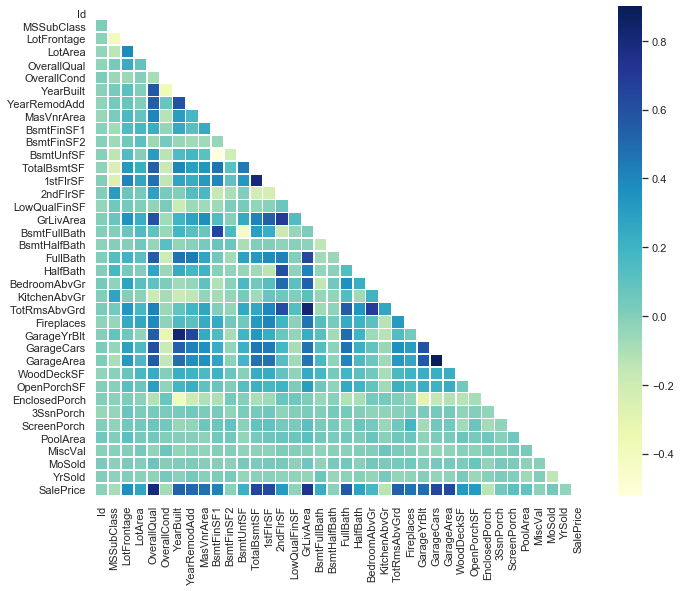

In [30]:
# 绘制关系矩阵
corrmat = train.corr()
mask = np.zeros_like(corrmat) # 返回相同大小的0矩阵
mask[np.triu_indices_from(mask)] = True # triu_indices_from: 函数的上三角矩阵
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, mask=mask, linewidths=.5, vmax=0.9, square=True, cmap="YlGnBu")

+ __接下来构建尽可能多的与房屋价格相关的新的特征，然后通过算法模型进行重要特征选择。__

In [31]:
full_data.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])

SalePrice                
                     mean    median count
MSSubClass                               
120         200779.080460  192000.0    87
150                   NaN       NaN     0
160         138647.380952  146000.0    63
180         102300.000000   88500.0    10
190         129613.333333  128250.0    30
20          185224.811567  159250.0   536
30           95829.724638   99900.0    69
40          156125.000000  142500.0     4
45          108591.666667  107500.0    12
50          143302.972222  132000.0   144
60          240403.542088  216000.0   297
70          166772.416667  156000.0    60
75          192437.500000  163500.0    16
80          169736.551724  166500.0    58
85          147810.000000  140750.0    20
90          133541.076923  135980.0    52

+ __按照下面的规则映射__  
                {'180' : 1
                '30' : 2   '45' : 2
                '190' : 3, '50' : 3, '90' : 3,
                '85' : 4, '40' : 4, '160' : 4
                '70' : 5, '20' : 5, '75' : 5, '80' : 5, '150' : 5
                '120': 6, '60' : 6}

+ __不同的人对如何映射这些值可能有不同的看法，所以只要跟随你的直觉。下面，我还在特征前面添加了一个小“o”，以便保留原来的特征，以便稍后使用get_dummies。__

In [32]:
def map_values():
    full_data["oMSSubClass"] = full_data.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    full_data["oMSZoning"] = full_data.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    full_data["oNeighborhood"] = full_data.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    full_data["oCondition1"] = full_data.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    full_data["oBldgType"] = full_data.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    full_data["oHouseStyle"] = full_data.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    full_data["oExterior1st"] = full_data.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    full_data["oMasVnrType"] = full_data.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    full_data["oExterQual"] = full_data.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full_data["oFoundation"] = full_data.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    full_data["oBsmtQual"] = full_data.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    full_data["oBsmtExposure"] = full_data.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    full_data["oHeating"] = full_data.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    full_data["oHeatingQC"] = full_data.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full_data["oKitchenQual"] = full_data.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full_data["oFunctional"] = full_data.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    full_data["oFireplaceQu"] = full_data.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full_data["oGarageType"] = full_data.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    full_data["oGarageFinish"] = full_data.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    full_data["oPavedDrive"] = full_data.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    full_data["oSaleType"] = full_data.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    full_data["oSaleCondition"] = full_data.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                
                        
    return "Done!"

In [33]:
map_values()

'Done!'

In [34]:
full_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,oHeating,oHeatingQC,oKitchenQual,oFunctional,oFireplaceQu,oGarageType,oGarageFinish,oPavedDrive,oSaleType,oSaleCondition
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,5,5,3,3,1,4,3,3,1,3
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,5,5,2,3,3,4,3,3,1,3
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,5,5,3,3,3,4,3,3,1,3
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,5,4,3,3,4,2,2,3,1,2
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,5,5,3,3,3,4,3,3,1,3


In [36]:
# drop two unwanted columns
# full.drop("LotAreaCut",axis=1,inplace=True)
full_data.drop(['SalePrice'],axis=1,inplace=True)

In [37]:
full_data.shape

(2917, 101)

## Pipeline

+ __建立一个管道，方便进行特征整合__

+ __将3个"Year"特征进行LabelEncoder转换__

In [39]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        return X

+ __对连续变量根据其偏度skewness进行box-cox变换__

Box-Cox变换是Box和Cox在1964年提出的一种广义幂变换方法，用于连续的响应变量不满足正态分布的情况。Box-Cox变换之后，可以一定程度上减小不可观测的误差和预测变量的相关性。Box-Cox变换的主要特点是引入一个参数，通过数据本身估计该参数进而确定应采取的数据变换形式

In [40]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5, lam=0.15):
        self.skew = skew
        self.lam = lam
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = boxcox1p(X[skewness_features], self.lam)
        X = pd.get_dummies(X)
        return X

In [41]:
full_data.select_dtypes(exclude=["object"]).apply(lambda x: x.skew()).sort_values(ascending=False)

MiscVal           21.950962
PoolArea          17.697766
LotArea           13.116240
3SsnPorch         11.377932
BsmtFinSF2         4.146636
EnclosedPorch      4.004404
ScreenPorch        3.947131
oSaleType          2.977069
MasVnrArea         2.623068
OpenPorchSF        2.530660
WoodDeckSF         1.845741
1stFlrSF           1.257933
LotFrontage        1.103606
GrLivArea          1.069300
oMasVnrType        1.047809
oBsmtExposure      1.008626
BsmtFinSF1         0.981149
BsmtUnfSF          0.920161
2ndFlrSF           0.861999
oExterQual         0.783859
TotRmsAbvGrd       0.749618
Fireplaces         0.725651
TotalBsmtSF        0.672097
OverallCond        0.569607
oKitchenQual       0.437698
oNeighborhood      0.373932
oFireplaceQu       0.315242
oExterior1st       0.275204
GarageArea         0.216968
OverallQual        0.189688
FullBath           0.165599
oFoundation        0.145082
oGarageFinish      0.136777
GarageCars        -0.219410
oHouseStyle       -0.306284
oSaleCondition    -0

In [42]:
# build pipeline
pipe = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=0.75)),
    ])

In [43]:
# save the original data for later use
full2 = full_data.copy()

In [44]:
data_pipe = pipe.fit_transform(full2)

In [45]:
data_pipe.shape

(2917, 405)

In [46]:
data_pipe.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5.831328,19.212182,7,5,110,53,8.059126,11.170327,0.0,7.483296,...,0,0,0,1,0,0,0,0,1,0
1,6.221214,19.712205,6,8,83,26,0.000000,12.062832,0.0,8.897844,...,0,0,0,1,0,0,0,0,1,0
2,5.914940,20.347241,7,5,108,52,7.646538,10.200343,0.0,9.917060,...,0,0,0,1,0,0,0,0,1,0
3,5.684507,19.691553,7,5,25,20,0.000000,8.274266,0.0,10.468500,...,0,0,0,1,1,0,0,0,0,0
4,6.314735,21.325160,8,5,107,50,9.391827,10.971129,0.0,10.221051,...,0,0,0,1,0,0,0,0,1,0


+ __当数据包含许多异常值，使用均值和方差缩放可能并不是一个很好的选择。这种情况下，可以使用 robust_scale 以及 RobustScaler 作为替代品。__

In [51]:
scaler = RobustScaler()

In [52]:
n_train=train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

### 特征选择 Feature Selection

组合不同的特征通常是一个好方法，但是我们不知道应该选择什么特征。幸运的是，有一些模型可以提供特征选择，这里我使用Lasso，但你可以自由选择Ridge、RandomForest或GradientBoostingTree。后来发现这里sklearn中提供了使用模型进行特征选择的方法。下面是手动操作的方法。

In [57]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [58]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipe.columns)

In [59]:
FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
GrLivArea,0.170770
OverallQual,0.099793
oMSZoning,0.077322
YearBuilt,0.066156
TotalBsmtSF,0.056720
...,...
SaleCondition_Abnorml,-0.017732
BsmtFullBath_0.0,-0.019454
KitchenAbvGr_2,-0.024720
CentralAir_N,-0.033857


(array([-0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ]),
 <a list of 8 Text xticklabel objects>)

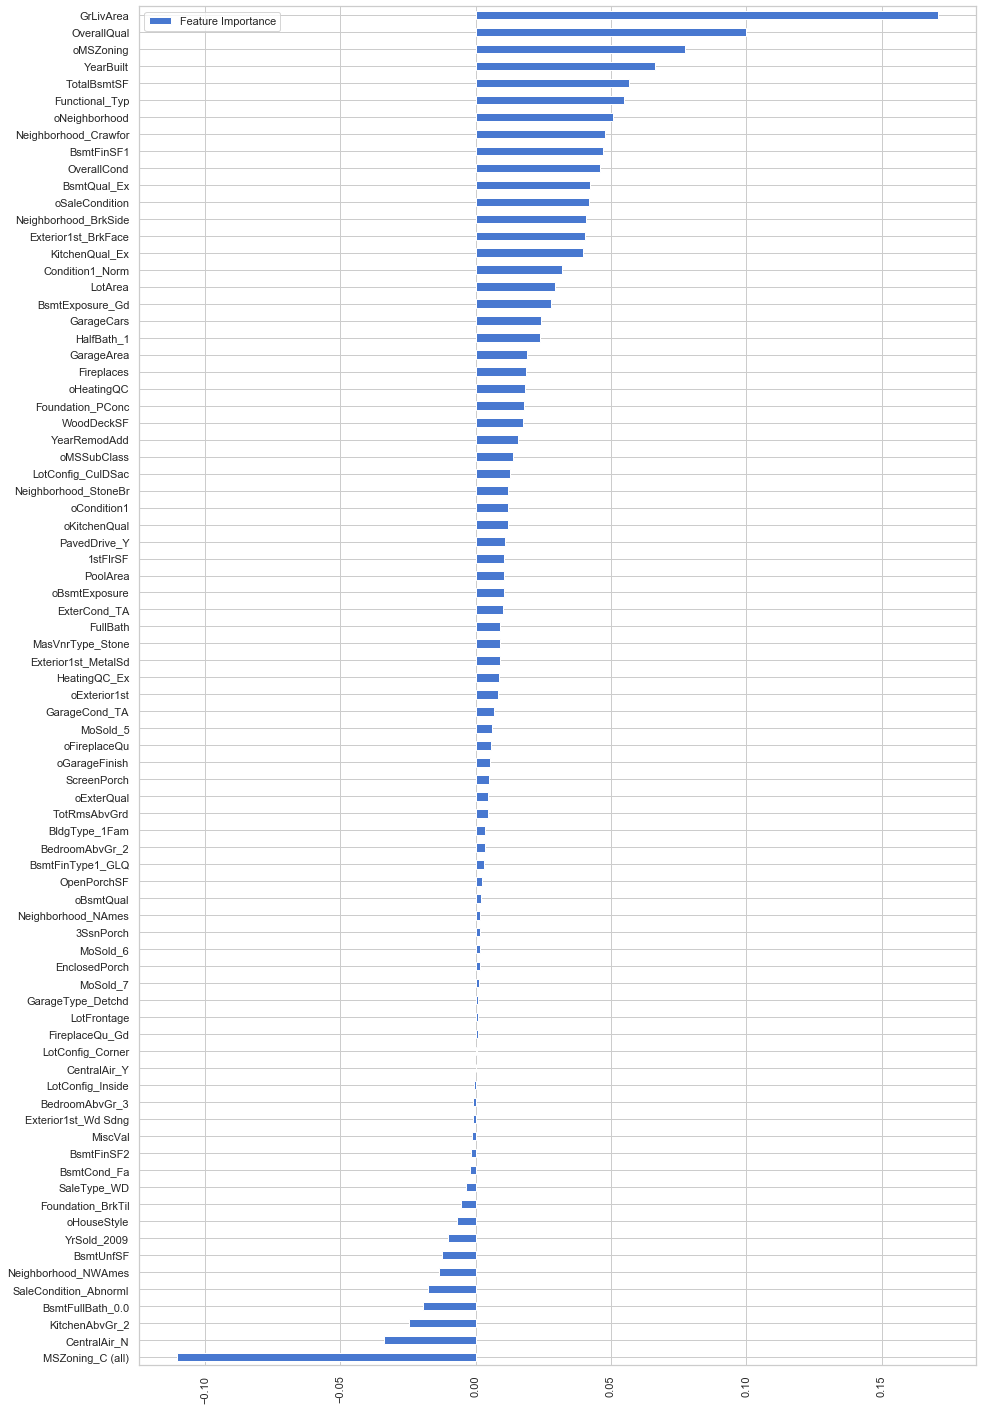

In [60]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)

+ __下面再构建添加一些新的特征，然后进行特征选择__

In [61]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
            return X

In [62]:
pipe = Pipeline([
    ('labenc', labelenc()),
    ('add_feature', add_feature(additional=2)),
    ('skew_dummies', skew_dummies(skew=0.75)),
    ])

## PCA

+ __Im my case, doing PCA is very important. It lets me gain a relatively big boost on leaderboard. At first I don't believe PCA can help me, but 
in retrospect, maybe the reason is that the features I built are highly correlated, and it leads to multicollinearity. PCA can decorrelate these features.__

+ __So I'll use approximately the same dimension in PCA as  in the original data. Since the aim here is not deminsion reduction.__

In [63]:
full_pipe = pipe.fit_transform(full_data)

In [64]:
full_pipe.shape

(2917, 426)

In [65]:
n_train=train.shape[0]
X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

In [66]:
pca = PCA(n_components=410)

In [67]:
X_scaled=pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)

In [68]:
X_scaled.shape, test_X_scaled.shape

((1458, 410), (1459, 410))

# 建模与模型评估

In [69]:
# define cross validation strategy
n_folds = 5
def rmse_cv(model,X,y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse

+ __选择下列模型(虽然有的算法我不熟)并使用5折交叉验证来评估各模型.__

Models included:

+ LinearRegression
+ Ridge
+ Lasso
+ Random Forest
+ Gradient Boosting Tree
+ Support Vector Regression
+ Linear Support Vector Regression
+ ElasticNet
+ Stochastic Gradient Descent
+ BayesianRidge
+ KernelRidge
+ ExtraTreesRegressor
+ XgBoost

In [70]:
# 大部分算法使用sklearn默认超参数
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [71]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 37197358824.414337, 50718349042.6579
Ridge: 0.118386, 0.0091
Lasso: 0.120644, 0.0054
RF: 0.141074, 0.0093
GBR: 0.128015, 0.0073
SVR: 0.141850, 0.0135
LinSVR: 0.122072, 0.0081
Ela: 0.111675, 0.0054
SGD: 0.149120, 0.0111
Bay: 0.111136, 0.0058
Ker: 0.109801, 0.0051
Extra: 0.133504, 0.0056
Xgb: 0.143281, 0.0125


+ __接下来，我们进行一些超参数调优。首先定义一个gridsearch方法__

In [72]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

### Lasso

In [73]:
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0009],'max_iter':[10000]})

{'alpha': 0.0009, 'max_iter': 10000} 0.11150271791651226
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.112171        0.001284
1  {'alpha': 0.0005, 'max_iter': 10000}         0.111857        0.001227
2  {'alpha': 0.0007, 'max_iter': 10000}         0.111608        0.001154
3  {'alpha': 0.0009, 'max_iter': 10000}         0.111503        0.001059


### Ridge

In [74]:
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 60} 0.1108225708828761
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.110947        0.001221
1  {'alpha': 40}         0.110890        0.001201
2  {'alpha': 45}         0.110853        0.001185
3  {'alpha': 50}         0.110832        0.001172
4  {'alpha': 55}         0.110823        0.001162
5  {'alpha': 60}         0.110823        0.001153
6  {'alpha': 65}         0.110830        0.001146
7  {'alpha': 70}         0.110844        0.001141
8  {'alpha': 80}         0.110887        0.001132
9  {'alpha': 90}         0.110946        0.001126


### SVR

In [75]:
grid(SVR()).grid_get(X_scaled,y_log,{'C':[11,13,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, 'kernel': 'rbf'} 0.10909673506350731
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.109325   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.109104   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.109295   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.109097   
4   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.109231   
5   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.109106   
6   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.109214   
7   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.109118   
8   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.109179   
9   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.109183   
10  {'C': 15, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.109163   
11  {'C': 15, 'epsilon': 0.009

### Kernel Ridge

In [76]:
param_grid={'alpha':[0.2,0.3,0.4], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1]}
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)

{'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kernel': 'polynomial'} 0.10912844693494346
                                              params  mean_test_score  \
0  {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.109385   
1  {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.109406   
2  {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.109532   
3  {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.109128   
4  {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.109926   
5  {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.109134   

   std_test_score  
0        0.001057  
1        0.001093  
2        0.001039  
3        0.001060  
4        0.001035  
5        0.001042  


### ElasticNet

In [77]:
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3],'max_iter':[10000]})

{'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': 10000} 0.11158201215747568
                                              params  mean_test_score  \
0  {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.115635   
1  {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.115147   
2  {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.112723   
3  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.111790   
4  {'alpha': 0.004, 'l1_ratio': 0.1, 'max_iter': ...         0.111713   
5  {'alpha': 0.004, 'l1_ratio': 0.3, 'max_iter': ...         0.112080   
6  {'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter':...         0.111643   
7  {'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': ...         0.111582   
8  {'alpha': 0.005, 'l1_ratio': 0.3, 'max_iter': ...         0.112716   

   std_test_score  
0        0.001829  
1        0.001778  
2        0.001438  
3        0.001247  
4        0.001209  
5        0.001045  
6        0.001195  
7        0.001162  
8        0.00105

# 集成方法

### 简单投票

In [79]:
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

In [87]:
ereg = VotingRegressor(estimators=[('lasso', lasso), ('ridge', ridge), 
                                   ('svr', svr), ('ker', ker), 
                                   ("ela", ela), ("bay", bay)])

In [88]:
score = rmse_cv(ereg, X_scaled, y_log)
print(score.mean())

0.10900912881751246


+ __但是当只计算其中两个模型平均时，会得到一个稍微有些提升的结果__

In [85]:
ereg_2 = VotingRegressor(estimators=[('svr', svr), ('ker', ker)])

In [86]:
score = rmse_cv(ereg_2, X_scaled, y_log)
print(score.mean())

0.10744749412206123


## Stacking

In [94]:
estimators=[('lasso', lasso), ('ridge', ridge), ('svr', svr), ('ker', ker), ("ela", ela), ("bay", bay)]

reg = StackingRegressor(estimators=estimators,final_estimator=Ridge(alpha=60))

In [95]:
score = rmse_cv(reg, X_scaled, y_log)
print(score.mean())

0.11103840856587106


In [97]:
reg.fit(X_scaled, y_log)

StackingRegressor(cv=None,
                  estimators=[('lasso',
                               Lasso(alpha=0.0005, copy_X=True,
                                     fit_intercept=True, max_iter=10000,
                                     normalize=False, positive=False,
                                     precompute=False, random_state=None,
                                     selection='cyclic', tol=0.0001,
                                     warm_start=False)),
                              ('ridge',
                               Ridge(alpha=60, copy_X=True, fit_intercept=True,
                                     max_iter=None, normalize=False,
                                     random_state=None, solver='auto',
                                     tol=0....
                               BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                             alpha_init=None,
                                             compute_score=False, copy_X=True,
   

In [100]:
ereg.fit(X_scaled, y_log)

VotingRegressor(estimators=[('lasso',
                             Lasso(alpha=0.0005, copy_X=True,
                                   fit_intercept=True, max_iter=10000,
                                   normalize=False, positive=False,
                                   precompute=False, random_state=None,
                                   selection='cyclic', tol=0.0001,
                                   warm_start=False)),
                            ('ridge',
                             Ridge(alpha=60, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001)),
                            ('sv...
                                        max_iter=10000, normalize=False,
                                        positive=False, precompute=False,
                                        random_state=None, selection='cyclic',
     

### Submission

In [101]:
pred = np.exp(ereg.predict(test_X_scaled))

In [102]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("../data/house_price_submission.csv",index=False)